In [528]:

import numpy as np
import pandas as pd
import re

# Para visualizar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import bokeh.plotting as bkplt
from bokeh.io import output_file, show
from bokeh.layouts import gridplot, column
from bokeh.models import HoverTool, Div


#contenido
from nltk.corpus import stopwords
from wordcloud import WordCloud
import emoji
from collections import Counter

In [529]:
mi_nombre = "ari"

In [530]:

file = open(r'C:/Users/Ariel Fleiderman/Downloads/Chat de WhatsApp con ari.txt',mode='r',encoding="utf8")
data = file.read()
file.close()

In [531]:
def split_text(data):
 
    return data.splitlines()

In [532]:
LineasChat = split_text(data)

In [533]:

len(LineasChat)

1701

In [534]:
def fecha(LineasChat):
    fecha = []
    regTime = re.compile("\d+/\d+/\d+")
    for index, line in enumerate(LineasChat):
        matches = re.findall(regTime, line)
        if(len(matches) > 0):
            fecha.append(matches[0])
        else:
            fecha.append(None)
    return fecha

In [536]:

def mensaje(LineasChat):
    mensaje = []
    msgRegex = re.compile('.*?-\s[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?:\s+(.+)')
    for index, line in enumerate(LineasChat):
        matches = re.findall(msgRegex, line)
        if(len(matches) > 0):
            mensaje.append(matches[0])
        else:
            mensaje.append(None)

            
    return mensaje

In [537]:
def rtte(LineasChat):
    sender = []
    rtteRegex = re.compile('.*?-\s([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')
    for index, line in enumerate(LineasChat):
        matches = re.findall(rtteRegex, line)
        if(len(matches) > 0):
            sender.append(matches[0])
        else:
            sender.append(None)
            
    return sender

In [538]:

def mensaje(LineasChat):
    mensaje = []
    msgRegex = re.compile('.*?-\s[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?:\s+(.+)')
    for index, line in enumerate(LineasChat):
        matches = re.findall(msgRegex, line)
        if(len(matches) > 0):
            mensaje.append(matches[0])
        else:
            mensaje.append(None)

            
    return mensaje

In [539]:
fecha = fecha(LineasChat)
senders = rtte(LineasChat)
mensaje = mensaje(LineasChat)

In [540]:
zipped = list(zip(fecha, senders, mensaje))

In [541]:
df = pd.DataFrame(zipped, columns = ['Fecha' ,'Remitente', 'Mensaje'])
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [542]:

def split_count(text):

    emoji_list = []
    data = text
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

total_mensajes = df.shape[0]
media_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]
df["emoji"] = df["Mensaje"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Mensaje.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [543]:
print("Total mensajes: ",total_mensajes)
print("Multimedia: ",media_mensajes)
print("Emojis: ",emojis)
print("Links: ",links)

Total mensajes:  1633
Multimedia:  266
Emojis:  183
Links:  23


In [544]:
df['Cant letras'] = df['Mensaje'].apply(lambda s : len(s))
df['Cant Palabras'] = df['Mensaje'].apply(lambda s : len(s.split(' ')))

In [545]:
media_mensajes_df = df[df['Mensaje'] == '<Multimedia omitido>']
df2 = df.drop(media_mensajes_df.index)

Series de tiempo de los mensajes

In [546]:
totales = df2.groupby(["Fecha", "Remitente"]).agg(CantMsg=('Mensaje', 'count'), CantPalabras=('Cant Palabras', 'sum')).reset_index()

In [547]:

totales.index = pd.DatetimeIndex(totales.Fecha, dayfirst=True)
totales.drop("Fecha", axis=1, inplace=True)

In [548]:
totales['month'] = [d.strftime('%b') for d in totales.index]
totales['day'] = [d.strftime('%A') for d in totales.index]
totales = totales.sort_values(by = "Fecha")

In [549]:

totales_msg_mes = totales.groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes = totales_msg_mes.resample('MS').sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [550]:
totales_msg_mes_me = totales[totales["Remitente"]==mi_nombre].groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes_me = totales_msg_mes_me.resample('MS').sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [551]:

totales_msg_mes_not_me = totales[totales["Remitente"]!=mi_nombre].groupby(["Fecha"])["CantMsg", "CantPalabras"].sum()
totales_msg_mes_not_me = totales_msg_mes_not_me.resample('MS').sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [552]:
mi_hover_tool = HoverTool(
                tooltips=[("Fecha","@x{%F}"), ("Cantidad", "@y{int}")], formatters={"@x":"datetime"} )

def plottotal( x1, y1,  title, color,  y_axis_label):
    plot = bkplt.figure(x_axis_type="datetime", title=title,  plot_height=350, plot_width=650, tools = 'pan, box_zoom')
    plot.line(x1, y1,  legend_label="Valor de cada mes", color=color)
    plot.circle(x1, y1,   color=color)
    plot.xgrid.grid_line_color=None
    plot.ygrid.grid_line_alpha=0.5
    plot.xaxis.axis_label = 'Fecha'
    plot.yaxis.axis_label = y_axis_label
    plot.legend.location = 'bottom_left'
    plot.add_tools(mi_hover_tool)
    return plot

In [553]:
def plotcompartido( x1, y1, x2, y2, title, color, color2, y_axis_label):
    plot = bkplt.figure(x_axis_type="datetime", title=title,  plot_height=350, plot_width=650, tools = 'pan, box_zoom')
    plot.line(x1, y1,  legend_label="Cantidad enviada por mí", color=color)
    plot.circle(x1, y1,   color=color)
    plot.line(x2, y2,  color = color2, legend_label="Cantidad recibida")
    plot.square(x2, y2,  color = color2,  )
    plot.xgrid.grid_line_color=None
    plot.ygrid.grid_line_alpha=0.5
    plot.xaxis.axis_label = 'Fecha'
    plot.yaxis.axis_label = y_axis_label
    plot.legend.location = 'bottom_left'
    plot.add_tools(mi_hover_tool)
    return plot

In [554]:

plotMensajes = plottotal(totales_msg_mes.index, totales_msg_mes.CantMsg, "Total de mensajes", "blue", "Valores mes")


In [555]:
plotPalabras = plottotal(totales_msg_mes.index, totales_msg_mes.CantPalabras, "Total de palabras", "green", "Palabras por mes")


In [556]:
plotMensajes2 = plotcompartido(totales_msg_mes_me.index, totales_msg_mes_me.CantMsg, totales_msg_mes_not_me.index, totales_msg_mes_not_me.CantMsg, "Mensajes enviados", "red", "green", "Valores mes")

In [557]:

plotPalabras2 = plotcompartido(totales_msg_mes_me.index, totales_msg_mes_me.CantPalabras, totales_msg_mes_not_me.index, totales_msg_mes_not_me.CantPalabras, "Palabras enviadas", "red", "green", "Palabras por mes")

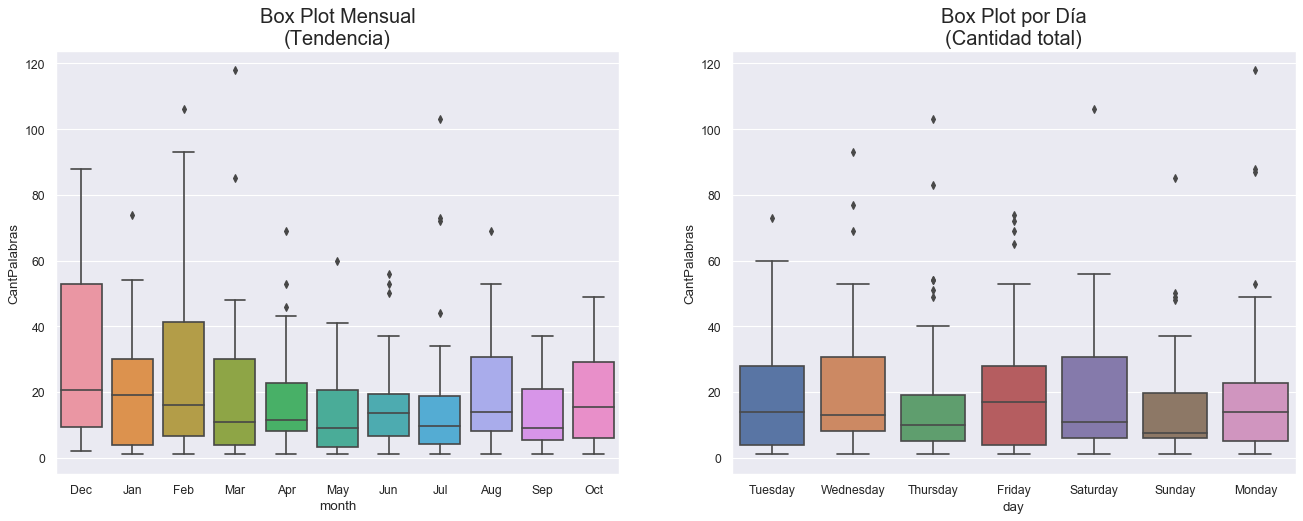

In [558]:

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y="CantPalabras", data=totales, ax=axes[0])
sns.boxplot(x='day', y='CantPalabras', data=totales)

axes[0].set_title('Box Plot Mensual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot por Día\n(Cantidad total)', fontsize=18)
plt.show()


Análisis de emojis

In [559]:

total_emojis_list = list([a for b in df2.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
agregados_emoji = emoji_df[(emoji_df['emoji'] == '♀')|(emoji_df['emoji'] == '🏻')]
emoji_df.drop(agregados_emoji.index, inplace=True)
emoji_df = emoji_df.head(10)
emoji_df

,emoji,count
0,👍,54
1,👏,18
2,😍,15
3,🥰,13
4,🎉,12
5,💪,12
6,😱,10
7,😘,9
8,🤣,9
9,😎,7


In [560]:
my_emojis_list = list([a for b in df2[df2['Remitente']==mi_nombre].emoji for a in b])
emoji_me_dict = dict(Counter(my_emojis_list))
emoji_me_dict = sorted(emoji_me_dict.items(), key=lambda x: x[1], reverse=True)

my_emoji_df = pd.DataFrame(emoji_me_dict, columns=['emoji', 'count'])
agregados_emoji_me = my_emoji_df[(my_emoji_df['emoji'] == '♀')|(my_emoji_df['emoji'] == '🏻')]
my_emoji_df.drop(agregados_emoji_me.index, inplace=True)
my_emoji_df = my_emoji_df.head(10)
my_emoji_df

,emoji,count
0,🎉,12
1,😱,10
2,👏,10
3,😎,7
4,😍,5
5,💪,5
6,😭,4
7,😆,2
8,👍,1


In [561]:

other_emojis_list = list([a for b in df2[df2['Remitente']!=mi_nombre].emoji for a in b])
emoji_other_dict = dict(Counter(other_emojis_list))
emoji_other_dict = sorted(emoji_other_dict.items(), key=lambda x: x[1], reverse=True)

other_emoji_df = pd.DataFrame(emoji_other_dict, columns=['emoji', 'count'])
agregados_emoji_other = other_emoji_df[(other_emoji_df['emoji'] == '♀')|(other_emoji_df['emoji'] == '🏻')]
other_emoji_df.drop(agregados_emoji_other.index, inplace=True)
other_emoji_df = other_emoji_df.head(10)
other_emoji_df

,emoji,count
0,👍,53
1,🥰,13
2,😍,10
3,😘,9
4,🤣,9
5,👏,8
6,💪,7
7,🎊,4
8,❤,3
9,👋,3


In [562]:

def buscarmax(df1, df2):
    if df1.max() > df2.max():
        maximo = df1.max()
    else:
        maximo = df2.max()
    return maximo
cantmaxemojis = buscarmax(my_emoji_df['count'], other_emoji_df['count'])
cantmaxemojis

53

In [567]:
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
from bokeh.palettes import Spectral9

source = ColumnDataSource(data=dict(emojis=emoji_df ['emoji'], counts=emoji_df ['count'], color=Spectral10))


b_emoji_df  = bkplt.figure(
  x_range=emoji_df['emoji'],
  y_range=(0,cantmaxemojis*1.1),
  title = 'total emojis más enviados',
  y_axis_label ='Cantidad veces utilizada',
  plot_width=650,
  plot_height=350,
  tools = 'pan, box_zoom'
)
b_emoji_df.vbar('emojis', width=0.6, top='counts', color='color', source=source,  fill_alpha=0.7,
                    #legend="emojis"
                   )

b_emoji_df.xaxis.major_label_text_font_size = '20px'


b_emoji_df.add_tools(mi_hover_tool2)


In [568]:
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
from bokeh.palettes import Spectral9

mi_hover_tool2 = HoverTool(
                tooltips=[("Cantidad","@counts"), ("Emoji", "@emojis")],  )
source = ColumnDataSource(data=dict(emojis=my_emoji_df['emoji'], counts=my_emoji_df['count'], color=Spectral9))
p_my_emojis = bkplt.figure(
  x_range=my_emoji_df['emoji'],
  y_range=(0,cantmaxemojis*1.1),
  title = 'Mis emojis más enviados',
  y_axis_label ='Cantidad veces utilizada',
  plot_width=650,
  plot_height=350,
  tools = 'pan, box_zoom'
)



p_my_emojis.xaxis.major_label_text_font_size = '20px'

p_my_emojis.vbar('emojis', width=0.6, top='counts', color='color', source=source,  fill_alpha=0.7, 
                 #legend="emojis"
                )



p_my_emojis.add_tools(mi_hover_tool2)


In [569]:
show(p_my_emojis)

In [292]:
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
from bokeh.palettes import Spectral9

source = ColumnDataSource(data=dict(emojis=other_emoji_df['emoji'], counts=other_emoji_df['count'], color=Spectral10))


a_other_emojis = bkplt.figure(
  x_range=other_emoji_df['emoji'],
  y_range=(0,cantmaxemojis*1.1),
  title = 'Sus emojis más enviados',
  y_axis_label ='Cantidad veces utilizada',
  plot_width=650,
  plot_height=350,
  tools = 'pan, box_zoom'
)
a_other_emojis.vbar('emojis', width=0.6, top='counts', color='color', source=source,  fill_alpha=0.7,
                    #legend="emojis"
                   )

a_other_emojis.xaxis.major_label_text_font_size = '20px'


a_other_emojis.add_tools(mi_hover_tool2)
show(a_other_emojis)

 Texto

In [570]:
textomensajes = df2['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textomensajes = textomensajes.translate(trans)

In [571]:
textomensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomensajes)

In [576]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_sp.update(["sip","nono","ahh", "ahhh","meno","ay","tene","nooo","ir","asi","tenia","iba","ser","estan","https","jajaj","pa", "eh", "si", "no", "ah", "che", "sisi", "sii","siii","aca","ahi","ahí","tmb","encima","re","desp","nah","tan", "siiii","oki","re","dp","porq","xq","tb","do","ma","capaz","so","vo","solo", "https", "http", "www"
                     ,"ary", "ok","hola"])


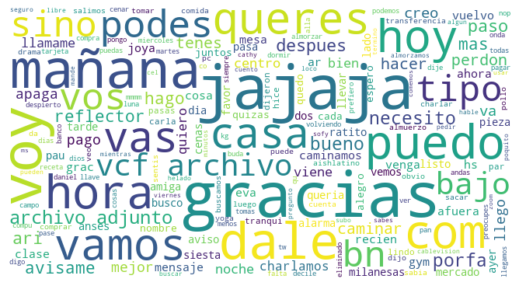

In [577]:
# Generate a word cloud image, 
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, collocation_threshold=100,  normalize_plurals=False).generate(textomensajes)
  # Display the generated image:
  # the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [579]:
textomismensajes = df2[df2['Remitente']==mi_nombre]['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textomismensajes = textomismensajes.translate(trans)


textomismensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textomismensajes)

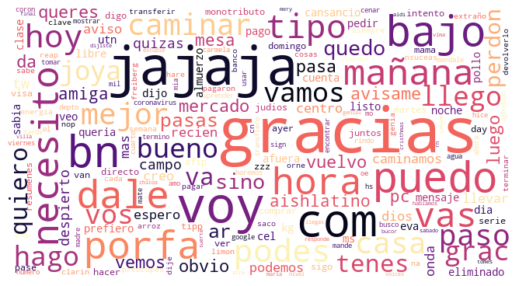

In [580]:
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, colormap="magma", collocation_threshold=100,  normalize_plurals=False).generate(textomismensajes)

  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [581]:

textosusmensajes = df2[df2['Remitente']!=mi_nombre]['Mensaje'].to_string().lower()
a,b = 'áéíóúü','aeiouu'
trans = str.maketrans(a,b)

textosusmensajes = textosusmensajes.translate(trans)
textosusmensajes = re.sub('\s*(j*a*ja\w*)\s\w*|(j*a*ja\w*)$', '\\1-jajaja ', textosusmensajes)

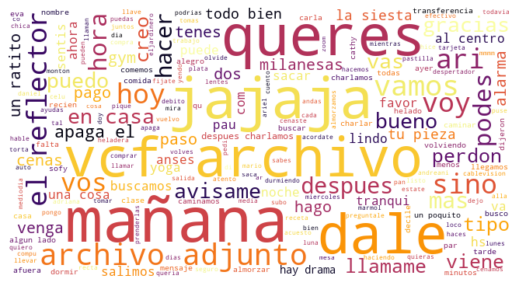

In [582]:
wordcloud = WordCloud(stopwords=stop_words_sp, background_color="white", width=650, height=350, max_font_size=80, colormap="inferno",  normalize_plurals=False).generate(textosusmensajes)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()